# Main

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time

In [2]:
path = 'C:/Users/Meier/Dropbox (Institut für Statistik)/Structural Breaks + DL/Simulation/Python Code/' 
# path = 'C:/Users/Johan/Desktop/Local/'
#path= 'C:/Users/Johan/Dropbox (Institut für Statistik)/Structural Breaks + DL/Simulation/Python Code/'
#path = 'C:/Users/Slave 1/Desktop/Johanna/'

In [3]:
str_model = 'RNN' # 'RNN', 'LSTM', 'GRU', 'AR', 'ARIMA', 'GARCH'
setting = 'AR' # 'AR', 'ARIMA', 'GARCH'

In [4]:
reps = 1000         # number of repetitions
no_sdl = 10       # number of sequential DL models to train
#ave = False       # return average predictions for sequential DL models

In [5]:
test_size = 0.1                                # proportion of test set
sim_length = 5000                              # length of simulated sample
#tau = np.array([0.7])  # break locations
#fac_beta = np.array([1])                 # break size factor
tau = np.array([0.1,0.4,0.7])  # break locations
fac_beta = np.array([0.5,1,2])                 # break size factor

In [6]:
test_size = 0.1           # proportion of test set
val_size = 0.2            # proportion of validation set
lags = 1                  # number of lags as features

In [7]:
if setting == 'AR':
    params = np.array([0.1,0.5,0.7,0.99,-0.5]) # AR (phi)
if setting == 'ARIMA':
    params = [np.array([0.1,0.5,0.9,0.95,0.99]),np.array([0.3,-0.3])] # ARIMA (phi, theta)
    params_list = list(itertools.product(params[0],params[1]))
    print(params_list)
if setting == 'GARCH':
    ! pip install arch
    params = [np.array([0.1,0.8]), np.array([0.45,0.45]), np.array([0.8,0.1])] # GARCH (phi,theta)

Run external notebooks.

In [8]:
%run "Helper_functions.ipynb" # notebook containing helper functions
%run "Simulate_data.ipynb" # notebook containing simulation function
%run "Split_data.ipynb" # notebook containing split function
%run "DL_models.ipynb" # notebook containing sequential deep learning models
%run "AR_model.ipynb" # notebook containing AR model
%run "ARIMA_model.ipynb" # notebook containing AR model
%run "GARCH_model.ipynb" # notebook containing AR model

Get names of simulation settings.

In [9]:
str_sims = get_str_sims(tau, fac_beta) # get names of simulation settings

Run simulation.

Simulation start: Tue Aug 30 09:59:41 2022
Repetition:  1
Parameter combination:  1 / 5
Dataset:  Ref ( 1 / 13 )
{'rmse': 0.25983805112845904, 'mae': 0.20840584, 'mape': 1.463359, 'r2': -0.0038121148427030516}


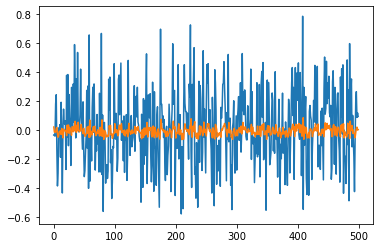

{'rmse': 0.25982139103542273, 'mae': 0.20860183, 'mape': 1.419055, 'r2': -0.0036834002753991513}


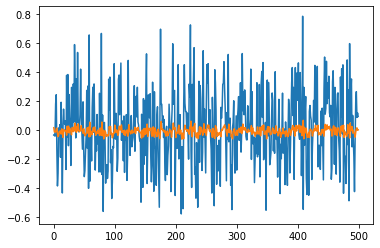

Dataset:  Tau0.1Ref ( 2 / 13 )
{'rmse': 0.2598361586415503, 'mae': 0.2084082, 'mape': 1.4780982, 'r2': -0.0037975361663333818}


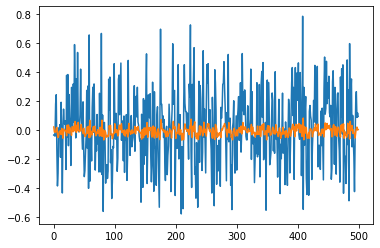

{'rmse': 0.25916106639394343, 'mae': 0.20888036, 'mape': 1.035938, 'r2': 0.0014117624688002595}


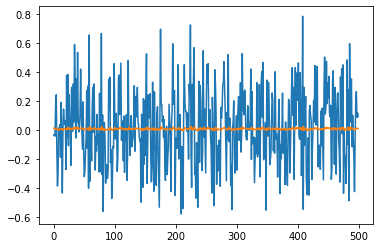

Dataset:  Tau0.1Beta0.5 ( 3 / 13 )
{'rmse': 0.2593576195650154, 'mae': 0.20778225, 'mape': 1.470738, 'r2': -0.00010335541198713827}


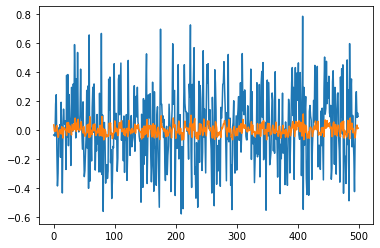

{'rmse': 0.25962196048670927, 'mae': 0.20861171, 'mape': 1.3551377, 'r2': -0.002143195340949422}


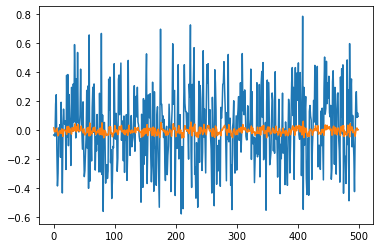

Dataset:  Tau0.1Beta1.0 ( 4 / 13 )
{'rmse': 0.2591158117651774, 'mae': 0.20819843, 'mape': 1.3259599, 'r2': 0.001760492888738252}


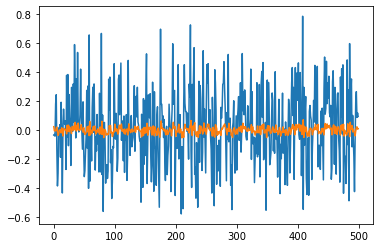

{'rmse': 0.2591372756350542, 'mae': 0.20813014, 'mape': 1.3544405, 'r2': 0.00159499689853837}


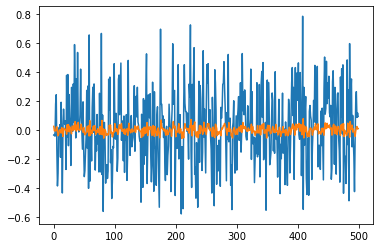

Dataset:  Tau0.1Beta2.0 ( 5 / 13 )
{'rmse': 0.25858115715873636, 'mae': 0.20776616, 'mape': 1.2356802, 'r2': 0.005875804355350067}


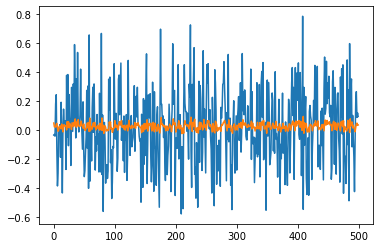

{'rmse': 0.25859124162269875, 'mae': 0.2076778, 'mape': 1.2597369, 'r2': 0.0057982805487432065}


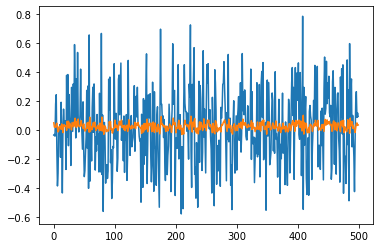

Dataset:  Tau0.4Ref ( 6 / 13 )
{'rmse': 0.2605585887740741, 'mae': 0.20885324, 'mape': 1.551727, 'r2': -0.009387017025174416}


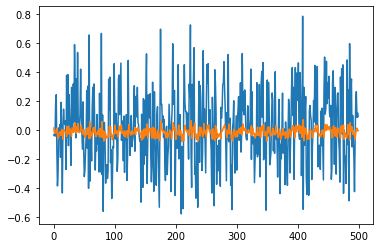

{'rmse': 0.25982434462379583, 'mae': 0.20912416, 'mape': 1.1692917, 'r2': -0.003706207079569257}


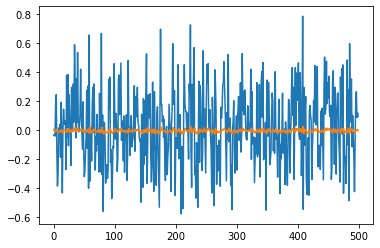

Dataset:  Tau0.4Beta0.5 ( 7 / 13 )
{'rmse': 0.25892757811379286, 'mae': 0.20794547, 'mape': 1.3279271, 'r2': 0.003210295407643504}


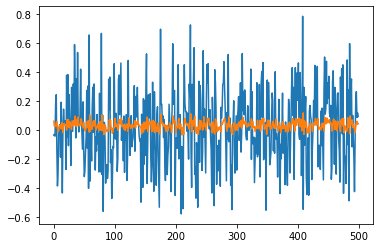

{'rmse': 0.258855818289714, 'mae': 0.20773648, 'mape': 1.3531885, 'r2': 0.003762883136934847}


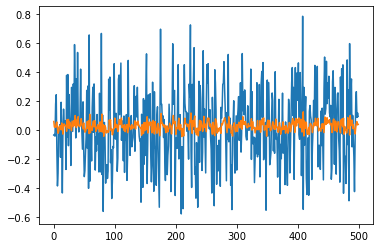

Dataset:  Tau0.4Beta1.0 ( 8 / 13 )
{'rmse': 0.26873208862322173, 'mae': 0.21729645, 'mape': 1.9552218, 'r2': -0.07370735760699754}


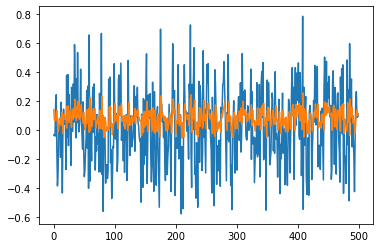

{'rmse': 0.2665504574263538, 'mae': 0.21507922, 'mape': 1.82626, 'r2': -0.056345051709287386}


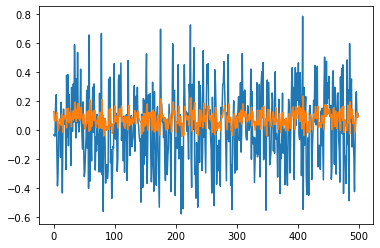

Dataset:  Tau0.4Beta2.0 ( 9 / 13 )
{'rmse': 0.2756010698885629, 'mae': 0.2225765, 'mape': 2.9692326, 'r2': -0.12929835492578357}


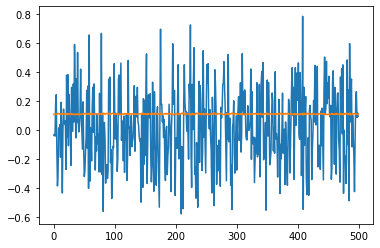

{'rmse': 0.29598238670053034, 'mae': 0.2403977, 'mape': 3.1174483, 'r2': -0.30250281481829133}


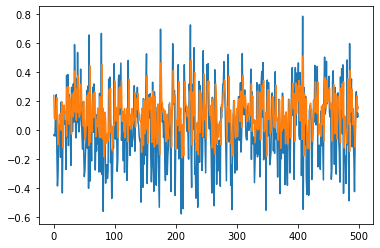

Dataset:  Tau0.7Ref ( 10 / 13 )
{'rmse': 0.2590510643527621, 'mae': 0.20811863, 'mape': 1.3321983, 'r2': 0.0022592741069579203}


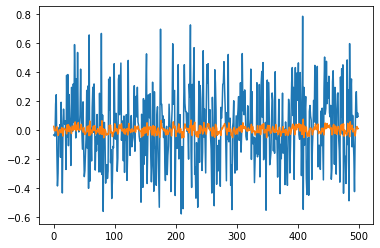

{'rmse': 0.25910586273751846, 'mae': 0.20810091, 'mape': 1.3534555, 'r2': 0.0018371769168467056}


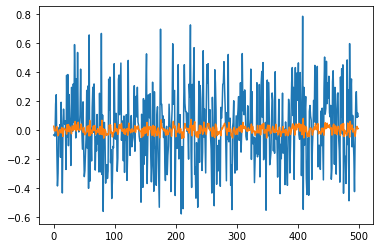

Dataset:  Tau0.7Beta0.5 ( 11 / 13 )
{'rmse': 0.2707672527589442, 'mae': 0.21888424, 'mape': 2.2992318, 'r2': -0.09003191313777026}


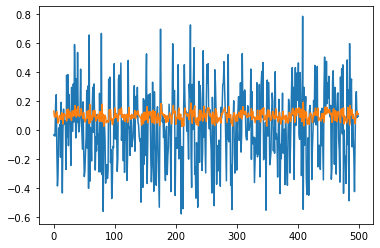

{'rmse': 0.2698038767969111, 'mae': 0.2180066, 'mape': 2.2344975, 'r2': -0.08228900894352087}


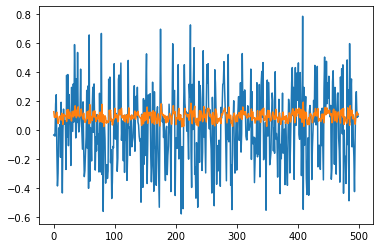

Dataset:  Tau0.7Beta1.0 ( 12 / 13 )
{'rmse': 0.3026196785505825, 'mae': 0.24681391, 'mape': 4.2684183, 'r2': -0.3615739259906674}


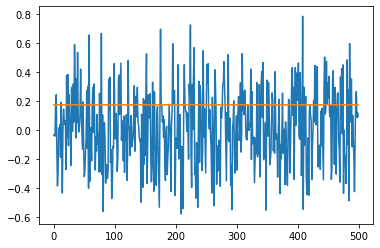

{'rmse': 0.3146962830947678, 'mae': 0.2585582, 'mape': 4.2303963, 'r2': -0.4724146415945807}


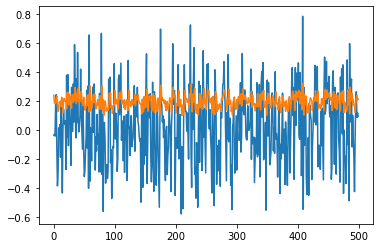

Dataset:  Tau0.7Beta2.0 ( 13 / 13 )
{'rmse': 0.3167340146880796, 'mae': 0.2594759, 'mape': 4.8107686, 'r2': -0.491544892945057}


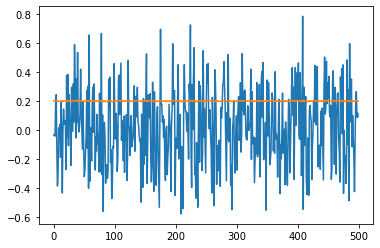

{'rmse': 0.38703510561251914, 'mae': 0.32148376, 'mape': 4.9226284, 'r2': -1.2271405606280736}


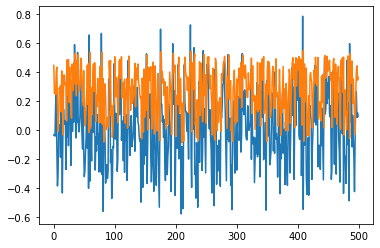

Parameter combination:  2 / 5
Dataset:  Ref ( 1 / 13 )
{'rmse': 0.22911561140740444, 'mae': 0.18508513, 'mape': 3.0055296, 'r2': 0.2789837647718758}


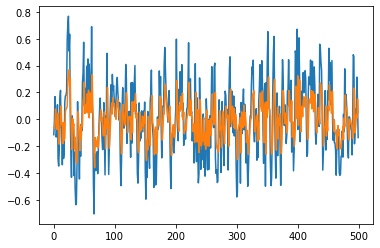

{'rmse': 0.2291228304826339, 'mae': 0.18514606, 'mape': 2.9985847, 'r2': 0.27893829034355644}


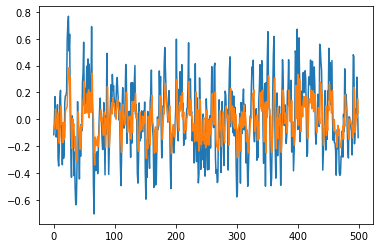

Dataset:  Tau0.1Ref ( 2 / 13 )
{'rmse': 0.22911774951307734, 'mae': 0.1850882, 'mape': 3.0209105, 'r2': 0.27897031986993515}


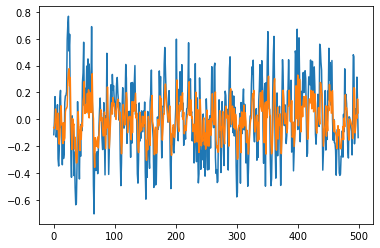

{'rmse': 0.22904308284933314, 'mae': 0.18506768, 'mape': 3.03112, 'r2': 0.27944010112322537}


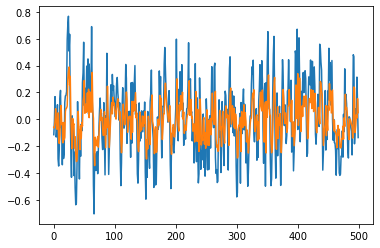

Dataset:  Tau0.1Beta0.5 ( 3 / 13 )
{'rmse': 0.228766084011762, 'mae': 0.18480578, 'mape': 3.0488868, 'r2': 0.2811819556387891}


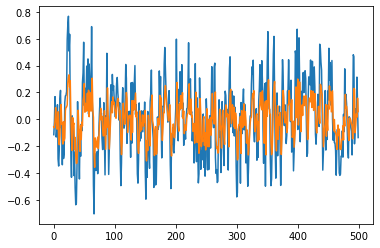

{'rmse': 0.2291548258077681, 'mae': 0.18511817, 'mape': 3.0449932, 'r2': 0.27873696509944346}


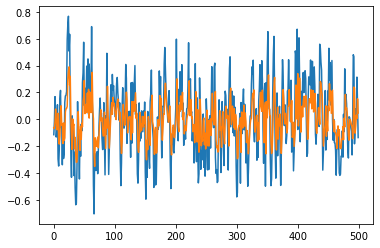

Dataset:  Tau0.1Beta1.0 ( 4 / 13 )
{'rmse': 0.22865366230785933, 'mae': 0.18469442, 'mape': 3.2497652, 'r2': 0.28188829919073755}


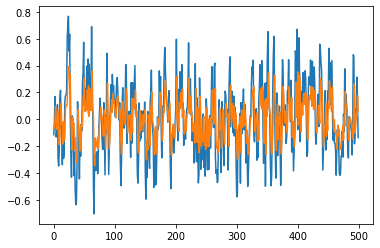

In [ ]:
# start timer
timer_start = time.time()
print('Simulation start: %s' %time.ctime(int(timer_start)))

# delete all files in Temp folder
emtpy_temp(path+'Temp/')

# run specified number of repetitions
for i in range(reps):
    
    # print repetition
    print('Repetition: ',i+1)
    
    # seed
    np.random.seed(i)
    
    # delete all simulation files in Temp folder
    del_sim(path+'Temp/')
    
    # simulate data for given setting and parameters(save csv-files in Temp)
    sim_data(setting=setting, params=params, tau=tau, fac_beta=fac_beta, test_size=test_size, l=sim_length, path=path+'Temp/', lags=1, verbose=False)
    
    # split all data into train, val, and test (save nzp-files in Temp)
    split_data(setting=setting, params=params, path=path+'Temp/', test_size=test_size, val_size=val_size)
    
    # check simulated data
    #sim = pd.read_csv(path+'Temp/sim1.csv' ,sep=',',na_values = 'NA')
    #data1 = np.load(path+'Temp/sim2_%s.npz' %sim.columns[0])
    #data2 = np.load(path+'Temp/sim2_%s.npz' %sim.columns[1])
    #plt.plot(data1['y_test'])
    #plt.plot(data2['y_test'])
    #plt.show()
    #del data1,data2
             
    # DL forecast
    # if DL: get combination forecasts
    if str_model == 'RNN' or str_model =='LSTM' or str_model =='GRU':
        
        #%run "DL_models.ipynb" # notebook containing sequential deep learning models
        
        # random seed for each model
        seed = np.random.randint(low=1,high=10000000,size=no_sdl) # number of models to run per dataset(random seeds)
        
        # set parameters
        input_dim = lags                  # number of lagged features in X
        hidden_dim = 10                   # number of hidden nodes per layer
        layer_dim = 1                     # number of layers
        output_dim = 1                    # output dimension (1 for univariate output)
        dropout = 0                       # dropout proportion (only before the last sequential layer)
        learning_rate = 1e-3              # learning rate for Adam optimizer
        weight_decay = 1e-6               # weight decay for Adam optimizer

        # save model parameters in dict
        model_params = {'input_dim': input_dim, 'hidden_dim' : hidden_dim,'layer_dim' : layer_dim, 'output_dim' : output_dim, 'dropout_prob' : dropout}
        
        # train model
        results = []
        #ave_results = []
        for j in range(len(params)):
        #for j in range(2):
            print('Parameter combination: ', j+1,'/',len(params))
            #results_seeds, sim_preds, best_seeds = train_loop(model_name=str_model,model_params=model_params,num_sim=j+1,str_sims=str_sims,path=path,seed=seed)
            results_seeds, best_seeds = train_loop(model_name=str_model,model_params=model_params,num_sim=j+1,str_sims=str_sims,path=path,seed=seed)
            results.append(np.squeeze(results_seeds[[np.arange(0,len(str_sims))],list(map(int, best_seeds)),:])) # shape: 1 x no. of settings x no. of metrics
        
            #if ave:
            #    ave_results_sets = []
            #    for l in range(len(str_sims)):
            #        ave_preds = np.mean(sim_preds,axis=1)[l,:,:]
            #        df_ave = pd.DataFrame(data={"value": ave_preds[:,0], "prediction": ave_preds[:,1]})
            #        ave_result_metrics = calculate_metrics(df_ave)
            #        df_ave_metrics = pd.DataFrame(np.expand_dims((ave_result_metrics['rmse'],ave_result_metrics['mae'],ave_result_metrics['mape'],ave_result_metrics['r2'],),axis=0),columns=['rmse','mae','mape','r2'])
            #        ave_results_sets.append(df_ave_metrics)
            #    ave_results_sets = np.expand_dims(np.squeeze(np.asarray(ave_results_sets)),axis=0) # shape: 1 x no. of settings x no. of metrics
            #    ave_results.append(ave_results_sets)
    
    # forecast AR model
    if str_model == 'AR':
        
        results = []
        for j in range(len(params)):
        #for j in range(2):
            print('Parameter combination: ', j+1,'/',len(params))
            df_sim = train_loop_ar(path=path,num_sim=j+1,str_sims=str_sims,plot_res=False)
            results.append(df_sim)
    
    # forecast ARIMA model
    if str_model == 'ARIMA':
        
        params_list = list(itertools.product(params[0],params[1]))
        
        results = []
        for j in range(len(params_list)):
        #for j in range(2):
            print('Parameter combination: ', j+1,'/',len(params_list))
            df_sim = train_loop_arima(path=path,num_sim=j+1,str_sims=str_sims)
            results.append(df_sim)
    
    # forecast GARCH model
    if str_model == 'GARCH':
        
        results = []
        for j in range(len(params)):
        #for j in range(2):
            print('Parameter combination: ', j+1,'/',len(params))
            df_sim = train_loop_garch(path=path,num_sim=j+1,str_sims=str_sims)
            results.append(df_sim)
        
    
    # save intermediate results
    new_results = np.expand_dims(np.asarray(results),axis=1)
    if i==0:
        np.save(path+'Temp/interm_results.npy',new_results)
    else:
        prev_results = np.load(path+'Temp/interm_results.npy')
        all_results = np.concatenate((prev_results,new_results),axis=1) # shape: no. of params x rep x no. of settings x no. of metrics
        np.save(path+'Temp/interm_results.npy',all_results)
        del prev_results
    
    # calculate metrics
    arr_results = np.load(path+'Temp/interm_results.npy')
    arr_mean, arr_std, arr_min, arr_max, arr_median = get_results(arr_results) # aggregate over reps (axis 1)  
    np.savez(path+'Results/'+setting+'_'+str_model+'_results.npz',mean=arr_mean,std=arr_std,minimum=arr_min,maximum=arr_max,median=arr_median)
    del arr_results
    
    # if predictions averaging is required
    #if ave and (str_model == 'RNN' or str_model =='LSTM' or str_model =='GRU'):
        
        # save intermediate results
        #new_ave_results = np.asarray(ave_results)
        #if i==0:
        #    np.save(path+'Temp/interm_ave_results.npy',new_ave_results)
        #else:
        #    prev_ave_results = np.load(path+'Temp/interm_ave_results.npy')
        #    all_ave_results = np.concatenate((prev_ave_results,new_ave_results),axis=1) # shape: no. of params x rep x no. of settings x no. of metrics
        #    np.save(path+'Temp/interm_ave_results.npy',all_ave_results)
        #    del prev_ave_results
    
        # calculate metrics
        #arr_ave_results = np.load(path+'Temp/interm_ave_results.npy')
        #arr_mean, arr_std, arr_min, arr_max, arr_median = get_results(arr_ave_results) # aggregate over reps (axis 1)  
        #np.savez(path+'Results/'+setting+'_'+str_model+'_ave_results.npz',mean=arr_mean,std=arr_std,minimum=arr_min,maximum=arr_max,median=arr_median) # shape: no. of parameters x no. of settings x no. of metrics
        #del arr_ave_results
    
    if (i < 10) | (i % 50 == 0):
        print('Elapsed: %s' %time_format(time.time() - timer_start))

print('Simulation end: %s' %time.ctime(int(time.time())))

In [ ]:
with np.load(path+'Results/'+setting+'_'+str_model+'_results.npz') as data:
    print(data['mean'].shape, data['std'].shape, data['minimum'].shape, data['maximum'].shape)